In [ ]:
import os

def count_images_in_folder(folder_path):
    """
    Đếm số lượng file ảnh trong một thư mục.

    Args:
        folder_path (str): Đường dẫn tới thư mục chứa ảnh.

    Returns:
        int: Số lượng file ảnh tìm được.
    """
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')
    count = sum(1 for file in os.listdir(folder_path) if file.lower().endswith(supported_extensions))
    return count

# Đường dẫn thư mục ảnh
folder_path = '/content/drive/MyDrive/AIP491/Datasets/OCR_Plates_0503/scale_and_crop_plates_test/scaled_plates'

# Gọi hàm và in kết quả
image_count = count_images_in_folder(folder_path)
print(f"Số lượng ảnh trong thư mục: {image_count}")


Số lượng ảnh trong thư mục: 743


In [ ]:
import os
import shutil

# Đường dẫn nguồn
image_src = '/content/drive/MyDrive/AIP491/Training/yolo_helmet/images/train_replace'
label_src = '/content/drive/MyDrive/AIP491/Training/yolo_helmet/labels/train_replace'

# Thư mục đích
dst_folder = '/content/drive/MyDrive/AIP491/Datasets/Augment_replace_nohelmet_0327'

# Tạo thư mục đích nếu chưa có
os.makedirs(dst_folder, exist_ok=True)

# Hàm copy file từ folder này sang folder khác
def copy_all_files(src_folder, dst_folder, extensions=None):
    for filename in os.listdir(src_folder):
        if extensions is None or filename.lower().endswith(extensions):
            src_path = os.path.join(src_folder, filename)
            dst_path = os.path.join(dst_folder, filename)
            shutil.copy2(src_path, dst_path)

# Copy ảnh (jpg, png, ...)
copy_all_files(image_src, dst_folder, extensions=('.jpg', '.jpeg', '.png', '.bmp', '.webp'))

# Copy nhãn (label - thường là .txt)
copy_all_files(label_src, dst_folder, extensions=('.txt',))

print("✅ Đã sao chép toàn bộ ảnh và label vào thư mục đích.")


✅ Đã sao chép toàn bộ ảnh và label vào thư mục đích.


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 1. Hàm tính thống kê dataset: tổng số ảnh, tổng số bounding box (labels),
def get_dataset_stats(image_dir, label_dir, image_exts=('.jpg', '.jpeg', '.png')):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
    label_files = [f for f in os.listdir(label_dir) if f.lower().endswith('.txt')]

    total_images = len(image_files)
    total_labels = 0
    images_with_labels = 0
    img_label_counts = {}

    for image_file in image_files:
        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            count = len(lines)
            total_labels += count
            if count > 0:
                images_with_labels += 1
            img_label_counts[image_file] = count
        else:
            img_label_counts[image_file] = 0

    image_basenames = set(os.path.splitext(f)[0] for f in image_files)
    label_files_without_image = 0
    for label_file in label_files:
        base_name = os.path.splitext(label_file)[0]
        if base_name not in image_basenames:
            label_files_without_image += 1

    stats = {
        'total_images': total_images,
        'total_labels': total_labels,
        'images_with_labels': images_with_labels,
        'images_without_labels': total_images - images_with_labels,
        'label_files_without_image': label_files_without_image,
        'img_label_counts': img_label_counts
    }
    return stats

# Hàm vẽ biểu đồ thống kê dataset (dùng cho tập train/valid)
def plot_dataset_stats(stats, title="Dataset Stats"):
    categories = ['Tổng ảnh', 'Ảnh có nhãn', 'Ảnh không có nhãn', 'Tổng nhãn', 'Label không có ảnh']
    values = [
        stats['total_images'],
        stats['images_with_labels'],
        stats['images_without_labels'],
        stats['total_labels'],
        stats['label_files_without_image']
    ]

    plt.figure(figsize=(8,5))
    bars = plt.bar(categories, values, color='skyblue')
    plt.title(title)
    plt.ylabel("Số lượng")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# 2. Hàm hiển thị ví dụ (visualize) ảnh kèm bounding box từ file label.
def visualize_example_data(image_dir, label_dir, num_examples=5, image_exts=('.jpg', '.jpeg', '.png')):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
    if len(image_files) == 0:
        print("Không tìm thấy ảnh trong thư mục:", image_dir)
        return
    examples = random.sample(image_files, min(num_examples, len(image_files)))

    plt.figure(figsize=(15, num_examples * 5))
    for i, image_file in enumerate(examples):
        img_path = os.path.join(image_dir, image_file)
        image = Image.open(img_path)
        draw = ImageDraw.Draw(image)
        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            for line in lines:
                parts = line.split()
                if len(parts) == 5:
                    cls, cx, cy, w, h = parts
                    cx, cy, w, h = float(cx), float(cy), float(w), float(h)
                    img_w, img_h = image.size
                    x_min = (cx - w/2) * img_w
                    y_min = (cy - h/2) * img_h
                    x_max = (cx + w/2) * img_w
                    y_max = (cy + h/2) * img_h
                    draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=2)
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(image)
        plt.title(f"Example: {image_file}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Hàm lấy kích thước ảnh và vẽ phân bố kích thước (width & height)
def get_image_sizes(image_dir, image_exts=('.jpg', '.jpeg', '.png')):
    sizes = []
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Không thể mở ảnh {img_path}: {e}")
    return sizes

import matplotlib.ticker as mticker
# 3. Xem phân bố kích thước ảnh
def plot_image_size_distribution(sizes, title="Phân bố kích thước ảnh"):
    if not sizes:
        print("Không có kích thước ảnh nào được thu thập.")
        return
    widths, heights = zip(*sizes)
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    axes[0].hist(widths, bins=20, color='lightgreen')
    axes[0].set_title("Phân bố width")
    axes[0].set_xlabel("Width (pixels)")
    axes[0].set_ylabel("Số ảnh")
    axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))

    axes[1].hist(heights, bins=20, color='lightblue')
    axes[1].set_title("Phân bố height")
    axes[1].set_xlabel("Height (pixels)")
    axes[1].set_ylabel("Số ảnh")
    axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:.1f}"))

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


# 4. Hàm kiểm tra phân bố class (class imbalance)
def check_class_imbalance(label_dir):
    label_files = [f for f in os.listdir(label_dir) if f.lower().endswith('.txt')]
    class_counts = {}
    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        for line in lines:
            parts = line.split()
            if len(parts) >= 1:
                cls = parts[0]
                class_counts[cls] = class_counts.get(cls, 0) + 1

    classes = list(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    plt.figure(figsize=(8,5))
    bars = plt.bar(classes, counts, color='orange')
    plt.title("Phân bố lớp (Class Imbalance)")
    plt.xlabel("Class")
    plt.ylabel("Số lượng")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    return class_counts

# 5. Hàm phân tích số lượng bounding box trên mỗi ảnh
def analyze_bboxes_per_image(image_dir, label_dir, image_exts=('.jpg', '.jpeg', '.png')):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
    bbox_counts = []
    for image_file in image_files:
        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            bbox_counts.append(len(lines))
        else:
            bbox_counts.append(0)

    plt.figure(figsize=(8,5))
    plt.hist(bbox_counts, bins=range(0, max(bbox_counts)+2), color='purple', align='left', rwidth=0.8)
    plt.title("Phân bố số bounding box trên mỗi ảnh")
    plt.xlabel("Số bounding box")
    plt.ylabel("Số ảnh")
    plt.tight_layout()
    plt.show()

    stats = {
        'mean': np.mean(bbox_counts),
        'median': np.median(bbox_counts),
        'max': np.max(bbox_counts),
        'min': np.min(bbox_counts)
    }
    return stats


In [ ]:
# Đường dẫn cho version 1
v1_image_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_Helmet_0113/train/images"
v1_label_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_Helmet_0113/train/labels"

# 1. Tính và vẽ thống kê dataset
v1_stats = get_dataset_stats(v1_image_dir, v1_label_dir)
plot_dataset_stats(v1_stats, title="Thống kê Dataset - Version 1")

# 2. Visualize example data
visualize_example_data(v1_image_dir, v1_label_dir, num_examples=5)

# 3. Xem phân bố kích thước ảnh
v1_sizes = get_image_sizes(v1_image_dir)
plot_image_size_distribution(v1_sizes, title="Phân bố kích thước ảnh - Version 1")

# 4. Kiểm tra phân bố class
v1_class_counts = check_class_imbalance(v1_label_dir)

# 5. Phân tích số bounding box trên mỗi ảnh
v1_bbox_stats = analyze_bboxes_per_image(v1_image_dir, v1_label_dir)
print("Thống kê số bounding box trên mỗi ảnh (Version 1):", v1_bbox_stats)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Đường dẫn cho version 2
v2_image_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/images"
v2_label_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/labels"

# 1. Tính và vẽ thống kê dataset
v2_stats = get_dataset_stats(v2_image_dir, v2_label_dir)
plot_dataset_stats(v2_stats, title="Thống kê Dataset - Version 2")

# 2. Visualize example data
visualize_example_data(v2_image_dir, v2_label_dir, num_examples=5)

# 3. Xem phân bố kích thước ảnh
v2_sizes = get_image_sizes(v2_image_dir)
plot_image_size_distribution(v2_sizes, title="Phân bố kích thước ảnh - Version 2")

# 4. Kiểm tra phân bố class
v2_class_counts = check_class_imbalance(v2_label_dir)

# 5. Phân tích số bounding box trên mỗi ảnh
v2_bbox_stats = analyze_bboxes_per_image(v2_image_dir, v2_label_dir)
print("Thống kê số bounding box trên mỗi ảnh (Version 2):", v2_bbox_stats)


Output hidden; open in https://colab.research.google.com to view.

**EDA DATA VERSION 2**

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from PIL import Image

#############################
# 1. Thời gian nào trong ngày có nhiều class 2 (no_helmet) nhất
#############################
def count_no_helmet_by_hour(image_dir, label_dir, image_exts=('.jpg', '.jpeg', '.png')):
    """
    Duyệt qua từng ảnh, trích xuất giờ từ tên file và đếm số bounding box có class 2 trong file label.
    Trả về dict: {hour: count} và hiển thị biểu đồ cột.
    """
    hour_counts = {h:0 for h in range(24)}
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]

    for image_file in image_files:
        parts = image_file.split('_')
        if len(parts) < 3:
            continue
        time_str = parts[2]
        try:
            hour = int(time_str[:2])
        except:
            continue

        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f if line.strip()]
            for line in lines:
                tokens = line.split()
                if tokens and tokens[0] == "2":
                    hour_counts[hour] += 1

    hours = list(hour_counts.keys())
    counts = list(hour_counts.values())
    plt.figure(figsize=(10,5))
    plt.bar(hours, counts, color='coral')
    plt.xlabel("Giờ trong ngày")
    plt.ylabel("Số lượng đối tượng class 2 (no_helmet)")
    plt.title("Phân bố số đối tượng no_helmet theo giờ")
    plt.xticks(hours)
    plt.show()

    # Tìm giờ có số lượng cao nhất
    max_hour = max(hour_counts, key=hour_counts.get)
    print(f"Giờ có nhiều đối tượng no_helmet nhất: {max_hour}:00 với {hour_counts[max_hour]} đối tượng")
    return hour_counts

#############################
# 2. Mức độ phân tán/tập trung của object (class 2) trên hình theo phân vùng (grid)
#############################
def plot_object_center_distribution_all(image_dir, label_dir, classes=["0", "1", "2", "3"], bins=20, image_exts=('.jpg', '.jpeg', '.png')):
    """
    Thu thập tọa độ trung tâm (cx, cy - normalized) của bounding box cho tất cả các lớp được chỉ định.
    Sau đó, hiển thị biểu đồ 2D (heatmap) cho mỗi lớp thể hiện mật độ tập trung của các đối tượng trên ảnh.

    Parameters:
      - image_dir: Thư mục chứa ảnh.
      - label_dir: Thư mục chứa file label (mỗi file có định dạng txt với mỗi dòng: class center_x center_y width height).
      - classes: Danh sách các lớp cần phân tích (mặc định là ["0", "1", "2", "3"]).
      - bins: Số bins dùng cho cả trục x và y trong histogram2d (mặc định 20).
      - image_exts: Các định dạng ảnh hợp lệ.
    """
    centers = {cls: {"x": [], "y": []} for cls in classes}

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]

    for image_file in image_files:
        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if not os.path.exists(label_path):
            continue
        with open(label_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        for line in lines:
            tokens = line.split()
            if len(tokens) < 5:
                continue
            cls = tokens[0]
            if cls in classes:
                try:
                    cx, cy = float(tokens[1]), float(tokens[2])
                    centers[cls]["x"].append(cx)
                    centers[cls]["y"].append(cy)
                except:
                    continue

    # Xác định số lớp cần vẽ
    n_classes = len(classes)
    if n_classes == 4:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
    else:
        n_rows = int(np.ceil(n_classes/2))
        fig, axes = plt.subplots(n_rows, 2, figsize=(12, 5*n_rows))
        axes = axes.flatten()

    for i, cls in enumerate(classes):
        ax = axes[i]
        x_data = centers[cls]["x"]
        y_data = centers[cls]["y"]
        if len(x_data) > 0:
            h = ax.hist2d(x_data, y_data, bins=bins, range=[[0,1],[0,1]], cmap='hot')
            ax.invert_yaxis()  # Đảo trục y để phù hợp với hệ tọa độ ảnh (0,0 ở góc trên trái)
            ax.set_title(f"Class {cls}")
            ax.set_xlabel("Normalized X")
            ax.set_ylabel("Normalized Y")
            fig.colorbar(h[3], ax=ax, label='Số lượng đối tượng')
        else:
            ax.text(0.5, 0.5, f"Không có dữ liệu cho class {cls}", horizontalalignment='center', verticalalignment='center')
            ax.set_title(f"Class {cls}")
            ax.set_xlabel("Normalized X")
            ax.set_ylabel("Normalized Y")
            ax.invert_yaxis()
    plt.suptitle("Phân bố tâm bounding box của các lớp đối tượng")
    plt.tight_layout()
    plt.show()

#############################
# 3. Crop và hiển thị các vùng chứa đối tượng no_helmet (class 2)
#############################
def crop_no_helmet_examples(image_dir, label_dir, num_examples=10, image_exts=('.jpg', '.jpeg', '.png')):
    """
    Duyệt qua ảnh, crop các bounding box có class 2 (no_helmet) từ file label (từ normalized sang pixel)
    và hiển thị một số ví dụ ngẫu nhiên để kiểm tra tính đa dạng của dữ liệu.
    Nếu bounding box không hợp lệ (x_max <= x_min hoặc y_max <= y_min), bỏ qua crop đó.
    """
    crops = []
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]

    for image_file in image_files:
        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        if not os.path.exists(label_path):
            continue
        try:
            img_path = os.path.join(image_dir, image_file)
            img = Image.open(img_path)
        except Exception as e:
            print(f"Lỗi mở ảnh {img_path}: {e}")
            continue

        img_w, img_h = img.size
        with open(label_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        for line in lines:
            tokens = line.split()
            if len(tokens) < 5:
                continue
            if tokens[0] == "2":  # class no_helmet
                cx, cy, w, h = map(float, tokens[1:5])
                # Tính tọa độ pixel cho bounding box
                x_min = int((cx - w/2) * img_w)
                y_min = int((cy - h/2) * img_h)
                x_max = int((cx + w/2) * img_w)
                y_max = int((cy + h/2) * img_h)

                # Chỉnh sửa tọa độ nếu vượt quá biên và kiểm tra tính hợp lệ
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_w, x_max)
                y_max = min(img_h, y_max)

                if x_max <= x_min or y_max <= y_min:
                    print(f"Bỏ qua crop trong ảnh {image_file} với bounding box không hợp lệ: ({x_min}, {y_min}, {x_max}, {y_max})")
                    continue

                crop_img = img.crop((x_min, y_min, x_max, y_max))
                crops.append(crop_img)

    if not crops:
        print("Không tìm thấy đối tượng no_helmet nào để crop.")
        return

    # Chọn ngẫu nhiên num_examples crop để hiển thị
    selected = random.sample(crops, min(num_examples, len(crops)))
    cols = 5
    rows = (len(selected) + cols - 1) // cols
    plt.figure(figsize=(15, 3*rows))
    for i, crop_img in enumerate(selected):
        plt.subplot(rows, cols, i+1)
        plt.imshow(crop_img)
        plt.title(f"Crop {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#############################
# 4. Đếm số lượng data ngày/dêm dựa theo thời gian trong tên ảnh
#############################
def count_day_night(image_dir, image_exts=('.jpg', '.jpeg', '.png')):
    """
    Phân loại ảnh theo ngày/dêm dựa trên giờ trong tên file.
    Giả sử: từ 06:00 đến 18:00 là 'Ngày', các giờ còn lại là 'Đêm'.
    """
    counts = {"Ngày": 0, "Đêm": 0}
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]

    for image_file in image_files:
        parts = image_file.split('_')
        if len(parts) < 3:
            continue
        time_str = parts[2]
        try:
            hour = int(time_str[:2])
        except:
            continue
        if 6 <= hour < 18:
            counts["Ngày"] += 1
        else:
            counts["Đêm"] += 1

    # Vẽ biểu đồ tròn
    plt.figure(figsize=(6,6))
    plt.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%", startangle=90, colors=['gold', 'lightskyblue'])
    plt.title("Tỷ lệ ảnh Ngày/Đêm")
    plt.show()

    print("Số lượng ảnh:")
    print(counts)
    return counts

#############################
# 5. So sánh phân bố theo điều kiện thời tiết.
#############################
def compare_distribution_by_weather(image_dir, label_dir, image_exts=('.jpg', '.jpeg', '.png')):
    """
    So sánh phân bố theo điều kiện thời tiết.

    Từ tên file ảnh (ví dụ: "CAM044_20250213_1058_Nang_52"), hàm sẽ trích xuất
    điều kiện thời tiết (ở token thứ 4, ví dụ: "Nang") và đếm:
      - Số lượng ảnh ứng với mỗi điều kiện thời tiết.
      - Tổng số đối tượng (bounding box) trong ảnh ứng với mỗi điều kiện thời tiết.

    Sau đó, hàm vẽ biểu đồ so sánh:
      - Biểu đồ số lượng ảnh theo điều kiện thời tiết.
      - Biểu đồ số lượng đối tượng theo điều kiện thời tiết.
    """
    weather_image_counts = {}
    weather_object_counts = {}

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)]
    for image_file in image_files:
        parts = image_file.split('_')
        if len(parts) < 4:
            continue
        weather = parts[3]
        weather_image_counts[weather] = weather_image_counts.get(weather, 0) + 1

        base_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')
        object_count = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f if line.strip()]
                object_count = len(lines)
        weather_object_counts[weather] = weather_object_counts.get(weather, 0) + object_count

    weather_conditions = sorted(list(set(list(weather_image_counts.keys()) + list(weather_object_counts.keys()))))
    image_counts = [weather_image_counts.get(weather, 0) for weather in weather_conditions]
    object_counts = [weather_object_counts.get(weather, 0) for weather in weather_conditions]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].bar(weather_conditions, image_counts, color='skyblue')
    axes[0].set_title("Số lượng ảnh theo điều kiện thời tiết")
    axes[0].set_xlabel("Điều kiện thời tiết")
    axes[0].set_ylabel("Số ảnh")

    axes[1].bar(weather_conditions, object_counts, color='salmon')
    axes[1].set_title("Số lượng đối tượng theo điều kiện thời tiết")
    axes[1].set_xlabel("Điều kiện thời tiết")
    axes[1].set_ylabel("Số đối tượng")

    plt.tight_layout()
    plt.show()

    print("Số lượng ảnh theo điều kiện thời tiết:")
    print(weather_image_counts)
    print("Số lượng đối tượng theo điều kiện thời tiết:")
    print(weather_object_counts)

    return weather_image_counts, weather_object_counts

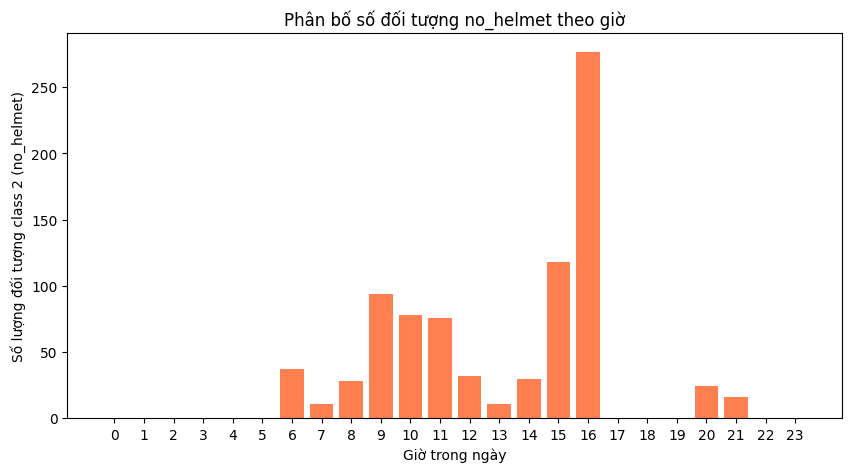

Giờ có nhiều đối tượng no_helmet nhất: 16:00 với 277 đối tượng


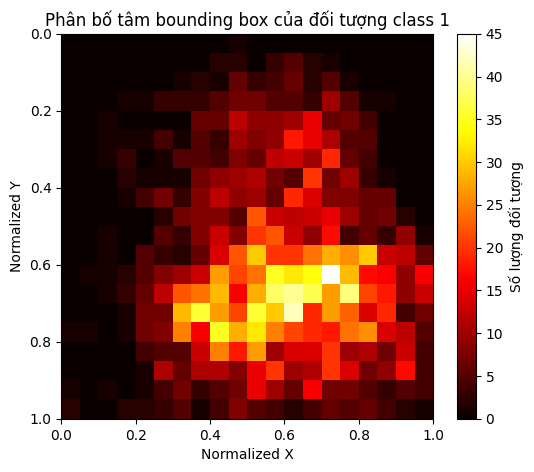

Bỏ qua crop trong ảnh CAM026_20250212_1627_Nang_5cc.jpg với bounding box không hợp lệ: (1145, 638, 1102, 591)


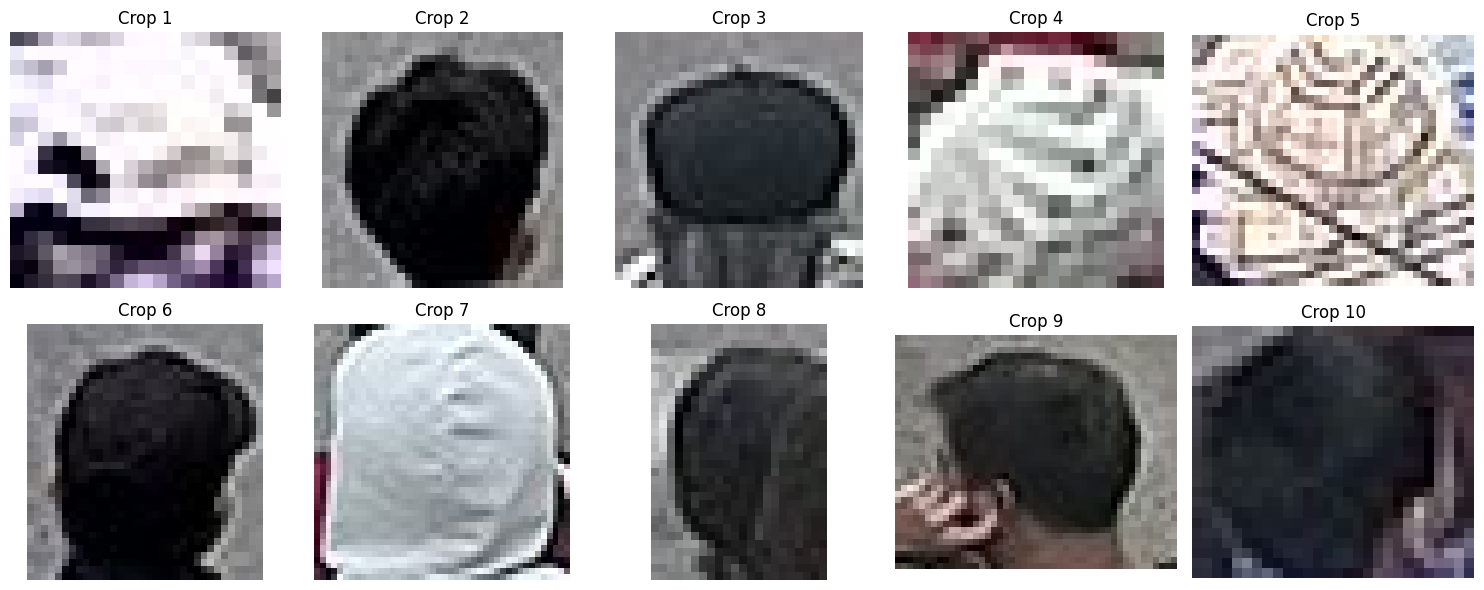

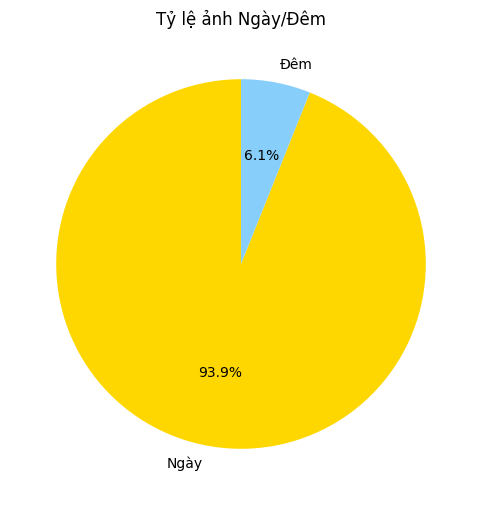

Số lượng ảnh:
{'Ngày': 665, 'Đêm': 43}


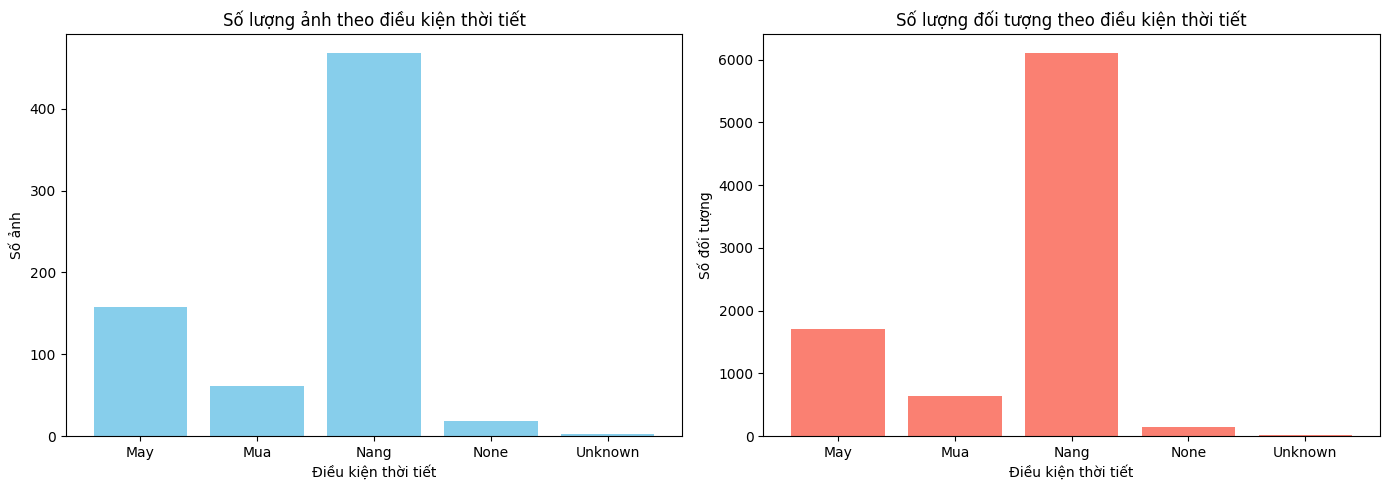

Số lượng ảnh theo điều kiện thời tiết:
{'Nang': 468, 'None': 18, 'Mua': 61, 'May': 158, 'Unknown': 3}
Số lượng đối tượng theo điều kiện thời tiết:
{'Nang': 6104, 'None': 147, 'Mua': 632, 'May': 1708, 'Unknown': 13}


In [ ]:
# Đường dẫn cho data version 2
v2_image_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/images"
v2_label_dir = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/labels"

# 1. Thời gian nào trong ngày có nhiều đối tượng no_helmet (class 2) nhất
hour_counts = count_no_helmet_by_hour(v2_image_dir, v2_label_dir)

# 2. Phân tích mức độ phân tán của đối tượng no_helmet trên ảnh (chia grid 3x3)
grid_counts = plot_object_center_distribution(v2_image_dir, v2_label_dir, target_class="1", bins=20)

# 3. Crop và hiển thị ví dụ đối tượng no_helmet
crop_no_helmet_examples(v2_image_dir, v2_label_dir, num_examples=10)

# 4. Đếm số lượng ảnh theo thời gian (Ngày/Đêm) dựa trên tên file
day_night_counts = count_day_night(v2_image_dir)

# 5. So sánh phân bố theo điều kiện thời tiết
weather_img_counts, weather_obj_counts = compare_distribution_by_weather(v2_image_dir, v2_label_dir)
